# Light Bulb Detector

Detecting which lightbulb you have from a phone picture to make changing your lights to energy efficient solutions really easy.

### Notebook: Simple Classifier

Approach the problem as a image classification problem. 

1. Datasets
2. Trained from Scratch Classifier (2 classes)
3. Transfer Learning Classifier (2 classes)
4. Transfer Learning Classifier (8 classes)


Background: What are some of the different lightbulbs.

E27<br>
E14<br>
B22<br>
B15<br>
GU10<br>
G4<br>
G9<br>
MR16<br>

Dataset creation: Gathered images using the 'ZIP' chrome add on from a google search of the bulb type. 

Dataset sizes - about 500 images of each class

Dataset quality is not very good. Some images have multiple images of the same bulb, mostly white backgrounds and some cases where you get a picture of the box. 

In [10]:
import pandas as pd
import numpy as np
import itertools
import os 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision.utils as utils
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.image as mpimg
import torchvision
from torchvision import models

import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

# Datasets

In [2]:
# TODO Replace file location with automated

In [3]:
folders = ['B15','B22','E14', 'E27', 'G4', 'G9','GU10', 'MR16']

def file_rename(folders):
    '''
    Function to rename all files taken from the internet from training. Used to rename
    all the file names to avoid really long file names and make it easier to know which
    bulb it is.
    
    Could be made more generic for other projects. Eg move out the base location into a parameter.
    
    input - folder names
    
    output - all files renamed in place. 
    
    '''
    
    for bulb_type in folders:

        location = r"C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data"
        location = location + '\\' + bulb_type + '\\'
        print(location)
        for count, filename in enumerate(os.listdir(location)): 
            dst = bulb_type + str(count) + ".jpg"
            src = location + filename 
            dst = location + dst  
            os.rename(src, dst) 

In [4]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=64,
                                                 num_workers=0 , sampler = train_sampler)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=4,
                                                 num_workers=0 , sampler = dev_sampler)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=4,
                                                 num_workers=0 , sampler = test_sampler)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# Create a pytorch dataset, and then dataloader to allow for mini-batch processing. 
# We can't use random crops as it might cut off the connector

data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ])
    
light_bulbs = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_data',
                                           transform=data_transform)

classes = light_bulbs.classes

In [7]:
train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])

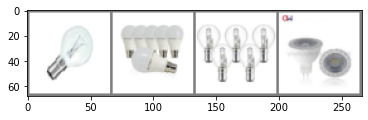

GroundTruth:    B15   B22   B15  MR16


In [8]:
dataiter = iter(test)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model

In [48]:
class BulbModel(nn.Module):
    
    '''
    class which defines the bulb classifier, forward prop, training and inference methods
    
    '''
    
    def __init__(self, num_classes):
        super(BulbModel, self).__init__()
        
        '''
        Initialise the model architecture
        '''
    
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.MaxPool2d(kernel_size =3 , stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), 
            nn.MaxPool2d(kernel_size =2 , stride=1, padding=0),
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(256, 512, 4, 2, 1, bias = False),
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace = True), 
            nn.Conv2d(512, 10, 4, 1, 0, bias = False), 
            nn.Flatten(),
            nn.Linear(90, 128),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )
        # Create a criterion. Lets use cross entropy loss. 
        self.criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        # create an optimiser for the classifier
        self.optimiser = optim.Adam(self.main.parameters(), lr=0.0001, betas = (0.9,0.999))
        
    def forward(self, input):
        '''
        Use to push an image through the network. 
        input is going to be an 3 channel image
        '''
        output = self.main(input)
        return output
    
   
    def weights_init(self):
        '''
        Defining the weights_init function that takes as input a neural network
        m and that will initialize all its weights.
        '''
        classname = self.__class__.__name__
        if classname.find('Conv') != -1:
            self.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            self.weight.data.normal_(1.0, 0.02)
            self.bias.data.fill_(0)
    
    def classifer_train(self, epochs_total, train):
        '''
        Function to train classifier based on training data and set epochs
        inputs: 
            - classifer
            - number of training epochs
            - training data
        '''
        error_monitoring = []

        for epoch in range(epochs_total):
            i = 1
            for data, labels in train:

                # create the prediction using the classifier
                prediction = self.forward(data)
                error = self.criterion(prediction, labels)
                #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

                # Update the weights
                self.zero_grad()
                error.backward()
                self.optimiser.step()

                i = i + 1

            #for each epoch record the final error
            error_monitoring.append(error)
            print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
            
    def inference(self, dataset_to_test_against):
        
        '''
        function to test how good the model
        input - dataset you want to test against
        
        output - confusion matrix and recall precision. 
        '''
        predictions_total = []
        labels_total = []

        with torch.no_grad():
            for data in dataset_to_test_against:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                for value in predicted:
                    predictions_total.append(value.item())
                for value in labels:
                    labels_total.append(value.item())    

        
        cm = confusion_matrix(labels_total, predictions_total)
        plot_confusion_matrix(cm, classes)

        from sklearn.metrics import precision_score, recall_score
        pre = precision_score(labels_total, predictions_total, average='micro')
        print('Precision {}'.format(round(pre,3)))
        rec = recall_score(labels_total, predictions_total, average='micro')
        print('Recall {}'.format(round(rec,3)))
        


In [47]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    ref - function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
    
    '''
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Trained from Scratch Classifier (2 or 3 classes)

In [55]:
# Create dataset just for number of classes:

NUM_CLASSES = 4

path_to_images = r'C:\Users\awalker8\Documents\COVID_Furlow\bulb_class\bulb_' + str(NUM_CLASSES) + '_class'


light_bulbs = datasets.ImageFolder(root=path_to_images,
                                           transform=data_transform)

train, dev, test = create_separate_train_dev_test(light_bulbs, percentages = [0.8,0.1,0.1])


classes = light_bulbs.classes

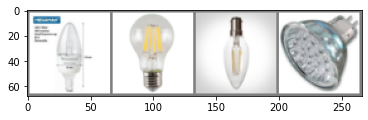

GroundTruth:    B15   E27   B15  MR16


In [56]:
dataiter = iter(test)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

[0/5][18/17] Loss: 1.2876
[1/5][18/17] Loss: 1.2560
[2/5][18/17] Loss: 1.1022
[3/5][18/17] Loss: 1.1261
[4/5][18/17] Loss: 1.0396
Confusion matrix, without normalization


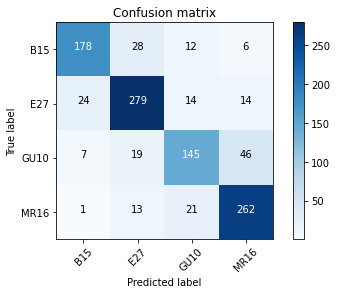

Precision 0.808
Recall 0.808
Confusion matrix, without normalization


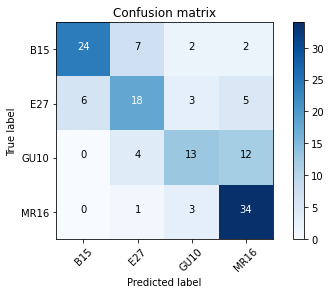

Precision 0.664
Recall 0.664
Confusion matrix, without normalization


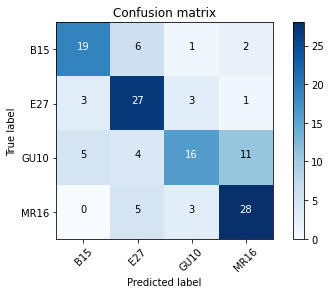

Precision 0.672
Recall 0.672


In [59]:
model = BulbModel(NUM_CLASSES)
model.weights_init()
model.classifer_train(5,train)

PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

model.inference(train)
model.inference(dev)
model.inference(test)

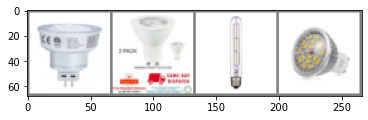

GroundTruth:   MR16  GU10   E27  GU10
Predicted  :   MR16   E27   E27  MR16


In [58]:
dataiter = iter(test)
images, labels = dataiter.next()

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                                for j in range(len(images))))

print('Predicted  : ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(images))))



# Transfer Learning

In [63]:
def retrainable_setup(model ,layers_limit):
    '''
    function that sets which layers of the network to retrain. 
    input 
    - layers_limit - number of layers to keep fixed.
    - model 
    
    output 
    - model - with layers set for training or not. 
    '''

    for param in model.parameters():
        param.requires_grad = False
    i = 0
    for child in model.children():
        for layer in child.children():
            i  +=1
            if i > layers_limit:
                for param in layer.parameters():
                    param.requires_grad = True
            else:
                for param in layer.parameters():
                    param.requires_grad = False


In [66]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\awalker8/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [68]:
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

In [69]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
retrainable_setup(model ,layers_limit = 27)

In [71]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_ft.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,178,564 total parameters.
11,178,564 training parameters.


In [61]:
modelVGG = models.vgg16(pretrained=True)

In [29]:
modelVGG.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 8),                   
                      nn.Softmax(dim=1))

In [30]:
modelVGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
model = modelVGG

In [32]:
retrainable_setup(model ,layers_limit = 27)

In [33]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,432 total parameters.
122,956,552 training parameters.


In [34]:
# create an optimiser for the classifier
optimiser_bulb_transfer = optim.Adam(model.parameters(), lr=0.01, betas = (0.9,0.999))
# Create a criterion. Lets use cross entropy loss. 
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

In [334]:
epochs_total = 25
for epoch in range(epochs_total):
    i = 1
    for data, labels in train:
     
        # push the image through the network
        prediction = model(data)
        
        error = criterion(prediction, labels)
        #print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
  
        # zero grad
        model.zero_grad()
        error.backward()
        optimiser_bulb_transfer.step()
        
        #if i == 10:
        #   break
            
        i = i + 1
    #for each epoch record the final error
    error_monitoring.append(error)
    print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))

[0/1][58/57] Loss: 2.2740


In [335]:
inference(model, dev)

[[ 0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0 43  0]
 [ 0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  1 51  0]
 [ 0  0  0  1  0  0 74  0]
 [ 0  0  0  0  0  0 53  0]
 [ 0  0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0 80  0]]
Precision 0.102
Recall 0.102


# Hyperparameter Testing 

In [47]:
# Testing different parameters. 

# Learning Rate

epochs_total = 200

results = {}

for learning_rate in [0.0001]:
#     modelVGG = models.vgg16(pretrained=True)
#     modelVGG.classifier[6] = nn.Sequential(
#                       nn.Linear(4096, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(256, 8),                   
#                       nn.Softmax(dim=1))
#     retrainable_setup(modelVGG ,layers_limit = 27)
    # create an optimiser for the classifier
    optimiser_bulb_transfer = optim.Adam(modelVGG.parameters(), lr=learning_rate, betas = (0.9,0.999))
    # Create a criterion. Lets use cross entropy loss. 
    criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    error_monitoring = []
    
    for epoch in range(epochs_total):
        i = 1
        for data, labels in train:

            # push the image through the network
            prediction = modelVGG(data)

            error = criterion(prediction, labels)

            # zero grad
            modelVGG.zero_grad()
            error.backward()
            optimiser_bulb_transfer.step()
            
            i = i + 1
        #for each epoch record the final error
        error_monitoring.append(error.item())
        print('[%d/%d][%d/%d] Loss: %.4f' % (epoch, epochs_total, i, len(train),error))
    
    results[learning_rate] = error_monitoring
        

[0/200][54/53] Loss: 1.3616
[1/200][54/53] Loss: 1.6073
[2/200][54/53] Loss: 1.2837
[3/200][54/53] Loss: 1.3573
[4/200][54/53] Loss: 1.3460
[5/200][54/53] Loss: 1.5240
[6/200][54/53] Loss: 1.3573
[7/200][54/53] Loss: 1.4440
[8/200][54/53] Loss: 1.2740
[9/200][54/53] Loss: 1.4407
[10/200][54/53] Loss: 1.3569
[11/200][54/53] Loss: 1.2740
[12/200][54/53] Loss: 1.5240
[13/200][54/53] Loss: 1.3573
[14/200][54/53] Loss: 1.2740
[15/200][54/53] Loss: 1.5189
[16/200][54/53] Loss: 1.4407
[17/200][54/53] Loss: 1.2740
[18/200][54/53] Loss: 1.3580
[19/200][54/53] Loss: 1.2740
[20/200][54/53] Loss: 1.5246
[21/200][54/53] Loss: 1.2740
[22/200][54/53] Loss: 1.2741
[23/200][54/53] Loss: 1.3573
[24/200][54/53] Loss: 1.5239
[25/200][54/53] Loss: 1.2740
[26/200][54/53] Loss: 1.2740
[27/200][54/53] Loss: 1.2740
[28/200][54/53] Loss: 1.7690
[29/200][54/53] Loss: 1.3573
[30/200][54/53] Loss: 1.4407
[31/200][54/53] Loss: 1.3573
[32/200][54/53] Loss: 1.3594
[33/200][54/53] Loss: 1.5240
[34/200][54/53] Loss: 1.

KeyboardInterrupt: 

In [50]:
results

{}

In [49]:
x_values = list(range(0,epochs_total))
for learning_rate in [0.0001]:
    plt.plot(x_values, results[learning_rate], label=learning_rate)

    plt.title('Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
plt.savefig('Learning_Rates')

KeyError: 0.0001

In [51]:
inference(model, dev)

[[ 1  7  3  5  7  9 14  4]
 [ 6  7  2  6 16  4 10  1]
 [ 0  8  7  5 15  9 10  2]
 [ 1 13  3  3 17 10  5  3]
 [ 3  6  2  5 12  8 10  3]
 [ 1  7  5  8  8  3 16  1]
 [ 3  5  5  5 11  9 12  1]
 [ 0  8  3  4 11  6 19  4]]
Precision 0.118
Recall 0.118
